# Part 1

In [29]:
import pandas as pd
import requests
from pathlib import Path
from Bio import SeqIO
from Bio.Blast import NCBIXML
from Bio import AlignIO
import scipy.stats
from collections import Counter
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

In [55]:
#Parse blast output
input_file = Path('Data/1_uniref50_blast_hits.xml')

with open(input_file) as f:
  blast_records = NCBIXML.parse(f)
  data = []

  # Iterate PSIBLAST rounds (here just one since it is a simple BLAST)
  for blast_record in blast_records:
      query_id = blast_record.query

      # Iterate alignments
      for i, alignment in enumerate(blast_record.alignments):
          subject_id = alignment.title

          # Iterate pairwise alignments
          for hsp in alignment.hsps:
              data.append((query_id,
                              subject_id,
                              blast_record.query_length,
                              hsp.query,
                              hsp.match,
                              hsp.sbjct,
                              hsp.query_start,
                              hsp.query_end,
                              hsp.sbjct_start,
                              hsp.sbjct_end,
                              hsp.identities,
                              hsp.positives,
                              hsp.gaps,
                              hsp.expect,
                              hsp.score))

              # Skip duplicated subjects
              break

df = pd.DataFrame(data, columns=["query_id", "subject_id", "query_len",
                                  "query_seq", "match_seq", "subject_seq",
                                "query_start", "query_end", "subject_start", "subject_end",
                                "identity", "positive", "gaps", "eval", "bit_score"])
df.iloc[100]

query_id                                                EMBOSS_001
subject_id       UR50:UniRef50_A0A183J3M9 Integrin beta n=1 Tax...
query_len                                                      247
query_seq        YPVDLYYLMDLSYSMKDDLERVRQLGHALLVRLQEVTHSVRIGFGS...
match_seq        YPVDLYYLMDLS+SM DD +++ +LG  L  ++ ++T + R+GFGS...
subject_seq      YPVDLYYLMDLSFSMADDKQKLTELGDLLAEKMTKITKNFRLGFGS...
query_start                                                      4
query_end                                                      247
subject_start                                                   83
subject_end                                                    321
identity                                                       123
positive                                                       175
gaps                                                            11
eval                                                           0.0
bit_score                                                    6

In [56]:
len(df)

200

In [57]:
# Get Uniref50 accessions
out_file = 'Data/1_uniref50_accessions.list'

with open(out_file, 'w') as fout:
  accessions = list(set([acc.split()[0].split(":")[1] for acc in df['subject_id']]))
  fout.write('\n'.join(accessions) + "\n")

- Accessions were used to retrieve Uniref50 sequences
- We then aligned them with ClustalOmega, and edited the alignment in Jalview by deleting rows with redundancy >= 95%, and deleting columns to the left and right of the most sonserved regions, going from around 7000 columns to around 250.
- We then generated the PSSM and HMM from the edited alignment, and used them to retrieve hits with PSI-Blast and HMMSEARCH against SwissProt

In [4]:
# let's look at entropies of the raw and edited alignment
raw_seqs = []  # [[...], ...]
with open("Data/1_uniref50_clustal_raw.fasta") as f:
    for record in AlignIO.read(f, "fasta"):
        raw_seqs.append(list(record.seq))
raw_seqs = np.array(raw_seqs, dtype="str")
edited_seqs=[]
with open("Data/1_uniref50_clustal_edited.fasta") as f:
    for record in AlignIO.read(f, "fasta"):
        edited_seqs.append(list(record.seq))
edited_seqs = np.array(edited_seqs, dtype="str")

In [7]:
aa = ["A", "R", "N", "D", "C", "E", "Q", "G", "H", "I", "L", "K", "M", "F", "P", "S", "T", "W", "Y", "V"]
raw_data = []
for i, column in enumerate(raw_seqs.T):

    # count AA in column
    count = Counter(column)
    count.pop('-')
    count_sorted = sorted(count.items(), key=lambda x:x[1], reverse=True)

    # count non gap AA
    non_gap = np.count_nonzero(column != "-")

    occupancy = non_gap / column.size

    # AA probability in column (gap excluded)
    # probabilities = [count.get(k, 0.0) / column.size for k in aa]
    probabilities = [count.get(k, 0.0) / non_gap for k in aa]

    # Zero entropy = complete conservation
    entropy = scipy.stats.entropy(probabilities, base=20)

    raw_data.append([i, occupancy, entropy, count_sorted])

raw_df = pd.DataFrame(raw_data, columns=['pos', 'occupancy', 'entropy', 'counts'])
edited_data = []
for i, column in enumerate(edited_seqs.T):

    # count AA in column
    count = Counter(column)
    try:
        count.pop('-')
    except:
        pass
    count_sorted = sorted(count.items(), key=lambda x:x[1], reverse=True)

    # count non gap AA
    non_gap = np.count_nonzero(column != "-")

    occupancy = non_gap / column.size

    # AA probability in column (gap excluded)
    # probabilities = [count.get(k, 0.0) / column.size for k in aa]
    probabilities = [count.get(k, 0.0) / non_gap for k in aa]

    # Zero entropy = complete conservation
    entropy = scipy.stats.entropy(probabilities, base=20)

    edited_data.append([i, occupancy, entropy, count_sorted])

edited_df = pd.DataFrame(edited_data, columns=['pos', 'occupancy', 'entropy', 'counts'])

<Axes: >

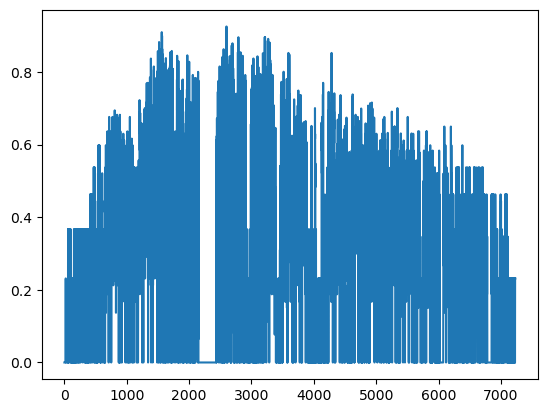

In [15]:
raw_df['entropy'].plot()

# Part 2

In [13]:
import requests
import json

## Collecting ground truth

In [3]:
# Collect ground truth

URL="https://www.ebi.ac.uk/interpro/api/protein/reviewed/entry/InterPro/IPR002369/"
headers={'Content-Type':'application/json'}
r=requests.get(URL,headers=headers)

In [38]:
r.json()

{'count': 46,
 'next': 'https://www.ebi.ac.uk/interpro/api/protein/reviewed/entry/InterPro/IPR002369/?cursor=source%3As%3Ap26011',
 'previous': None,
 'results': [{'metadata': {'accession': 'A2A863',
    'name': 'Integrin beta-4',
    'source_database': 'reviewed',
    'length': 1818,
    'source_organism': {'taxId': '10090',
     'scientificName': 'Mus musculus',
     'fullName': 'Mus musculus (Mouse)'}},
   'entries': [{'accession': 'IPR002369',
     'entry_protein_locations': [{'fragments': [{'start': 38,
         'end': 457,
         'dc-status': 'CONTINUOUS',
         'representative': False}],
       'model': None,
       'score': None}],
     'protein_length': 1818,
     'source_database': 'interpro',
     'entry_type': 'domain',
     'entry_integrated': None}]},
  {'metadata': {'accession': 'A5Z1X6',
    'name': 'Integrin beta-1',
    'source_database': 'reviewed',
    'length': 798,
    'source_organism': {'taxId': '9837',
     'scientificName': 'Camelus bactrianus',
     'ful

In [36]:
for node in r.json()['results']:
    print(node['entries'])

[{'accession': 'IPR002369', 'entry_protein_locations': [{'fragments': [{'start': 38, 'end': 457, 'dc-status': 'CONTINUOUS', 'representative': False}], 'model': None, 'score': None}], 'protein_length': 1818, 'source_database': 'interpro', 'entry_type': 'domain', 'entry_integrated': None}]
[{'accession': 'IPR002369', 'entry_protein_locations': [{'fragments': [{'start': 34, 'end': 464, 'dc-status': 'CONTINUOUS', 'representative': False}], 'model': None, 'score': None}], 'protein_length': 798, 'source_database': 'interpro', 'entry_type': 'domain', 'entry_integrated': None}]
[{'accession': 'IPR002369', 'entry_protein_locations': [{'fragments': [{'start': 34, 'end': 464, 'dc-status': 'CONTINUOUS', 'representative': False}], 'model': None, 'score': None}], 'protein_length': 798, 'source_database': 'interpro', 'entry_type': 'domain', 'entry_integrated': None}]
[{'accession': 'IPR002369', 'entry_protein_locations': [{'fragments': [{'start': 37, 'end': 460, 'dc-status': 'CONTINUOUS', 'representa

In [44]:
accessions=[]
names=[]
length=[]
taxon=[]
start=[]
end=[]
URL="https://www.ebi.ac.uk:443/interpro/api/protein/reviewed/entry/pfam/PF00362/"
headers={'Content-Type':'application/json'}
r=requests.get(URL,headers=headers)
for node in r.json()['results']:
        metadata=node['metadata']    
        entry=node['entries'][0]
        accessions.append(metadata['accession'])
        names.append(metadata['name'])
        length.append(metadata['length'])
        taxon.append(metadata['source_organism']['taxId'])
        start.append(entry['entry_protein_locations'][0]['fragments'][0]['start'])
        end.append(entry['entry_protein_locations'][0]['fragments'][0]['end'])
while r.json()['next']:
    URL=r.json()['next']
    r=requests.get(URL,headers=headers)
    for node in r.json()['results']:
        metadata=node['metadata']    
        entry=node['entries'][0]
        accessions.append(metadata['accession'])
        names.append(metadata['name'])
        length.append(metadata['length'])
        taxon.append(metadata['source_organism']['taxId'])
        start.append(entry['entry_protein_locations'][0]['fragments'][0]['start'])
        end.append(entry['entry_protein_locations'][0]['fragments'][0]['end'])

In [45]:
d={'accession':accessions,'name':names,'length':length,'taxon':taxon,'start':start,'end':end}
ground_truth=pd.DataFrame(data=d)

In [48]:
ground_truth.head()

,accession,name,length,taxon,start,end
0,A2A863,Integrin beta-4,1818,10090,128,370
1,A5Z1X6,Integrin beta-1,798,9837,138,382
2,B0FYY4,Integrin beta-1,798,9940,138,382
3,O54890,Integrin beta-3,787,10090,133,380
4,O70309,Integrin beta-5,798,10090,134,382


In [26]:
swissprot_IDs=pd.read_table('Data/swissprot_IDs.tsv',header=0)['Entry'].tolist()

In [27]:
swissprot_IDs

['A0A009IHW8',
 'A0A023I7E1',
 'A0A024B7W1',
 'A0A024SC78',
 'A0A024SH76',
 'A0A026W182',
 'A0A044RE18',
 'A0A059TC02',
 'A0A060A682',
 'A0A061ACU2',
 'A0A061AE05',
 'A0A061I403',
 'A0A067CMC7',
 'A0A067XGX8',
 'A0A067XH53',
 'A0A067XR63',
 'A0A067XRK9',
 'A0A067YMX8',
 'A0A068B6Q6',
 'A0A068J840',
 'A0A068Q5Q5',
 'A0A072UR65',
 'A0A072VDF2',
 'A0A075BSX9',
 'A0A075D5I4',
 'A0A075D657',
 'A0A075F7E9',
 'A0A075F932',
 'A0A075FBG7',
 'A0A075QQ08',
 'A0A075TJ05',
 'A0A075TMP0',
 'A0A075TMP8',
 'A0A075TR33',
 'A0A075TR41',
 'A0A075TRC0',
 'A0A075TRK9',
 'A0A075TRL5',
 'A0A075TXZ1',
 'A0A076FFM5',
 'A0A078CGE6',
 'A0A087WPF7',
 'A0A087X1C5',
 'A0A088MIT0',
 'A0A088MLT8',
 'A0A089QRB9',
 'A0A095AMW7',
 'A0A096MJN4',
 'A0A096MJY4',
 'A0A096MK47',
 'A0A096P8D3',
 'A0A097PTA8',
 'A0A0A0LLY1',
 'A0A0A1C3I2',
 'A0A0A1C930',
 'A0A0A1H8I4',
 'A0A0A1HA03',
 'A0A0A1I6E7',
 'A0A0A1I6N9',
 'A0A0A6ZFY4',
 'A0A0A7EPL0',
 'A0A0A7EQR3',
 'A0A0A7GEY4',
 'A0A0A7HFE1',
 'A0A0A7HIF0',
 'A0A0A7HIX6',
 'A0A0B0QJ

## Create confusion matrices

### Collect swissprot IDs

In [13]:
requestURL = "https://www.ebi.ac.uk/proteins/api/proteins?offset=0&size=-1&reviewed=true"
headers={'Accept':'application/json'}
r=requests.get(URL,headers=headers)

In [14]:
r.json()

{'requestedURL': 'https://www.ebi.ac.uk/proteins/api/proteins/',
 'errorMessage': ['At least one of these request parameters is required: accession, isoform, goterms, keywords, ec, gene, exact_gene, protein, organism, taxid, pubmed, seqLength or md5']}

### Parse PSI-BLAST results

In [64]:
psiblast_hits=pd.read_csv('Data/2_uniref50_pssm_hits.csv').iloc[:-1]
psiblast_hits.head()

,Description(Sequences with E-value BETTER than threshold),Scientific Name,Taxid,Max Score,Total Score,Query Cover,E value,Per. ident,Acc. Len,Accession
0,RecName: Full=Integrin beta-5; Flags: Precurso...,Bos taurus,9913,367,367,100%,3e-122,55.35,800,"=HYPERLINK(""https://www.ncbi.nlm.nih.gov/prote..."
1,RecName: Full=Integrin beta-5; Flags: Precurso...,Mus musculus,10090,366,366,100%,7e-122,55.81,798,"=HYPERLINK(""https://www.ncbi.nlm.nih.gov/prote..."
2,RecName: Full=Integrin beta-5; Flags: Precurso...,Homo sapiens,9606,366,366,100%,7e-122,55.35,799,"=HYPERLINK(""https://www.ncbi.nlm.nih.gov/prote..."
3,RecName: Full=Integrin beta-6; Flags: Precurso...,Mus musculus,10090,365,365,100%,1e-121,76.06,787,"=HYPERLINK(""https://www.ncbi.nlm.nih.gov/prote..."
4,RecName: Full=Integrin beta-6; Flags: Precurso...,Rattus norvegicus,10116,364,364,100%,2e-121,76.06,787,"=HYPERLINK(""https://www.ncbi.nlm.nih.gov/prote..."


In [65]:
pssm_accessions=[]
pssm_positions=[]
with open('Data/2_uniref50_pssm_aligns.fasta') as handle:
    for record in SeqIO.parse(handle,'fasta'):
        res=record.id.split(':')
        pssm_accessions.append(res[0].split('.')[0])
        pssm_positions.append(res[1])

In [66]:
pssm_start=[]
pssm_end=[]
for interval in pssm_positions:
    start,end=interval.split('-')
    pssm_start.append(int(start))
    pssm_end.append(int(end))

In [67]:
pssm_taxon=psiblast_hits['Taxid'].tolist()
pssm_evalue=psiblast_hits['E value'].tolist()
pssm_cover=psiblast_hits['Query Cover'].tolist()
pssm_identity=psiblast_hits['Per. ident'].tolist()
pssm_length=psiblast_hits['Acc. Len'].tolist()

In [75]:
pssm_data={'accession':pssm_accessions,'pred_start':pssm_start,'pred_end':pssm_end,'taxon':pssm_taxon,'evalue':pssm_evalue,
           'cover':pssm_cover,'identity':pssm_identity,'length':pssm_length}

In [76]:
uniref50_pssm_parsed_hits=pd.DataFrame(data=pssm_data)

In [77]:
uniref50_pssm_parsed_hits.to_csv('Data/2_uniref50_pssm_parsed_hits.csv')

### Protein confusion matrix

In [7]:
ground_truth=pd.read_csv('Data/2_ground_truth.csv')
uniref50_pssm_parsed_hits=pd.read_csv('Data/2_uniref50_pssm_parsed_hits.csv')

In [79]:
uniref50_pssm_parsed_hits

,Unnamed: 0,accession,pred_start,pred_end,taxon,evalue,cover,identity,length
0,0,P80747,108,322,9913,3.000000e-122,100%,55.35,800
1,1,O70309,108,322,10090,7.000000e-122,100%,55.81,798
2,2,P18084,108,322,9606,7.000000e-122,100%,55.35,799
3,3,Q9Z0T9,103,315,10090,1.000000e-121,100%,76.06,787
4,4,Q6AYF4,103,315,10116,2.000000e-121,100%,76.06,787
5,5,Q863C4,103,315,9940,6.000000e-121,100%,75.12,787
6,6,Q8SQB8,103,315,9913,6.000000e-121,100%,75.12,788
7,7,Q1RPR6,103,315,9823,7.000000e-121,100%,76.53,788
8,8,P07228,117,326,9031,9.000000e-121,100%,56.81,803
9,9,P18564,103,315,9606,1.000000e-120,100%,76.06,788


In [43]:
predicted_accessions=uniref50_pssm_parsed_hits['accession'].tolist()
true_accessions=ground_truth['accession'].tolist()

In [30]:
truth=[int(ID in true_accessions) for ID in swissprot_IDs]
pred=[int(ID in predicted_accessions) for ID in swissprot_IDs]
conf_matrix_pssm=confusion_matrix(truth,pred)

In [33]:
conf_matrix

array([[    46,      1],
       [     0, 570373]])

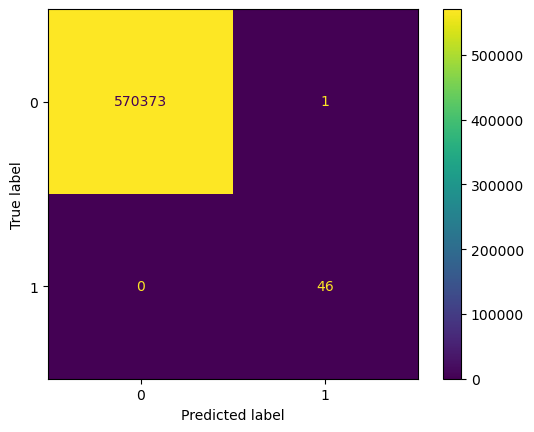

In [32]:
disp=ConfusionMatrixDisplay(conf_matrix_pssm)
disp.plot()

### Residue level results

In [34]:
merged_data=ground_truth.merge(uniref50_pssm_parsed_hits,on='accession',how='inner')

In [35]:
merged_data

,Unnamed: 0_x,accession,name,length_x,taxon_x,start,end,Unnamed: 0_y,pred_start,pred_end,taxon_y,evalue,cover,identity,length_y
0,0,A2A863,Integrin beta-4,1818,10090,128,370,43,101,311,10090,2.000000e-80,100%,40.47,1818
1,1,A5Z1X6,Integrin beta-1,798,9837,138,382,19,113,322,9837,8.000000e-118,100%,55.40,798
2,2,B0FYY4,Integrin beta-1,798,9940,138,382,14,113,322,9940,1.000000e-118,100%,55.40,798
3,3,O54890,Integrin beta-3,787,10090,133,380,24,107,320,10090,5.000000e-116,100%,56.54,787
4,4,O70309,Integrin beta-5,798,10090,134,382,1,108,322,10090,7.000000e-122,100%,55.81,798
5,5,P05106,Integrin beta-3,788,9606,134,381,18,108,321,9606,7.000000e-118,100%,57.94,788
6,6,P05107,Integrin beta-2,769,9606,122,367,29,97,307,9606,3.000000e-109,100%,47.42,769
7,7,P05556,Integrin beta-1,798,9606,138,382,13,113,322,9606,8.000000e-119,100%,55.40,798
8,8,P07228,Integrin beta-1,803,9031,142,386,8,117,326,9031,9.000000e-121,100%,56.81,803
9,9,P09055,Integrin beta-1,798,10090,138,382,11,113,322,10090,5.000000e-119,100%,55.87,798


In [40]:
tp=0
fp=0
fn=0
tn=0
for index,row in merged_data.iterrows():
    start=row['start']
    end=row['end']
    pred_start=row['pred_start']
    pred_end=row['pred_end']
    length=row['length_x']
    for i in range(length):
        if start <= i <= end:
            if pred_start <= i <= pred_end:
                tp +=1
            else:
                fn += 1
        else:
            if pred_start <= i <= pred_end:
                fp += 1
            else:
                tn += 1
res_pssm_matrix=np.array([[tn,fp],[fn,tp]])

In [41]:
res_pssm_matrix

array([[26350,  1233],
       [ 2636,  8302]])

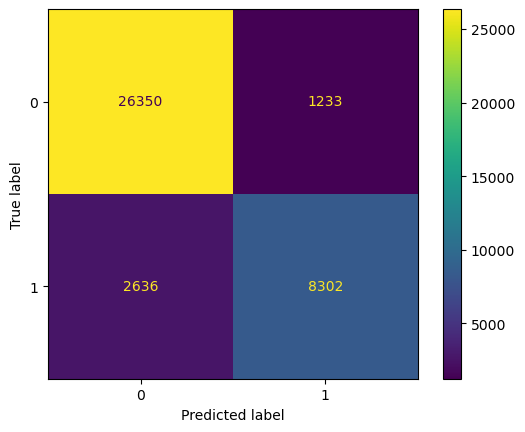

In [42]:
ConfusionMatrixDisplay(res_pssm_matrix).plot()